###**09.회귀 실습 - 자전거 대여 수요 예측**

캐글의 자전거 대여 수요(Bike Sharing Demand) 예측 경연에서 사용된 학습 데이터 세트를 이용하여 선형 회귀와 트리 기반 회귀를 비교해보도록 하자.

**데이터 설명**

train.csv

- datetime: hourly date + timestamp
- season: 1=봄, 2=여름, 3=가을, 4=겨울
- holiday: 1=토,일요일의 주말을 제외한 국경일 등의 휴일, 0=휴일이 아닌 날
- workingday: 1= 토,일요일의 주말 및 휴일이 아닌 주중, 0=휴일이 아닌 날
- weather: 1=맑음(약간 구름이낀 흐림), 2=안개(안개+흐림), 3=가벼운눈(가벼운 비+천둥), 4=심한 눈/비,천둥/번개
- temp: 온도(섭씨)
- atemp: 체감온도(섭씨)
- humidity: 상대습도
- windspeed: 풍속
- casual: 사전에 등록되지 않은 사용자가 대여한 횟수
- registered: 사전에 등록된 사용자가 대여한 횟수
- count: 대여 횟수

**데이터 클렌징 및 가공과 데이터 시각화**

bike_train.csv 데이터 세트를 이용하여 모델을 학습 후 대여 횟수(count)를 예측해보자

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


- 10886개의 레코드, 12개의 칼럼 구성 확인 가능

In [34]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- 대부분의 칼럼이 int 또는 float 숫자형이나, datetime 칼럼만 object형으로 존재 -> datetime 칼럼 가공 필요
- datetime의 경우 년-월-일-시:분:초의 문자형식으로 구성 -> 4개의 속성으로 분리 (년,월,일,시간)


In [35]:
#문자열을 datetime 타입으로 변경.
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년,월,일,시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x: x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


- 새롭게 year, month, date, hour의 칼럼이 추가된 것을 확인 가능 (datetime 칼럼은 삭제)
- casual + registered = count를 나타내므로 이들의 상관도가 높을 것으로 추측 가능 -> 해당 두 칼럼도 삭제

In [36]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

주요 칼럼별 Target값(count(대여횟수))이 어떻게 분포되어있는지 시각화 진행 => seaborn의 barplot함수 이용

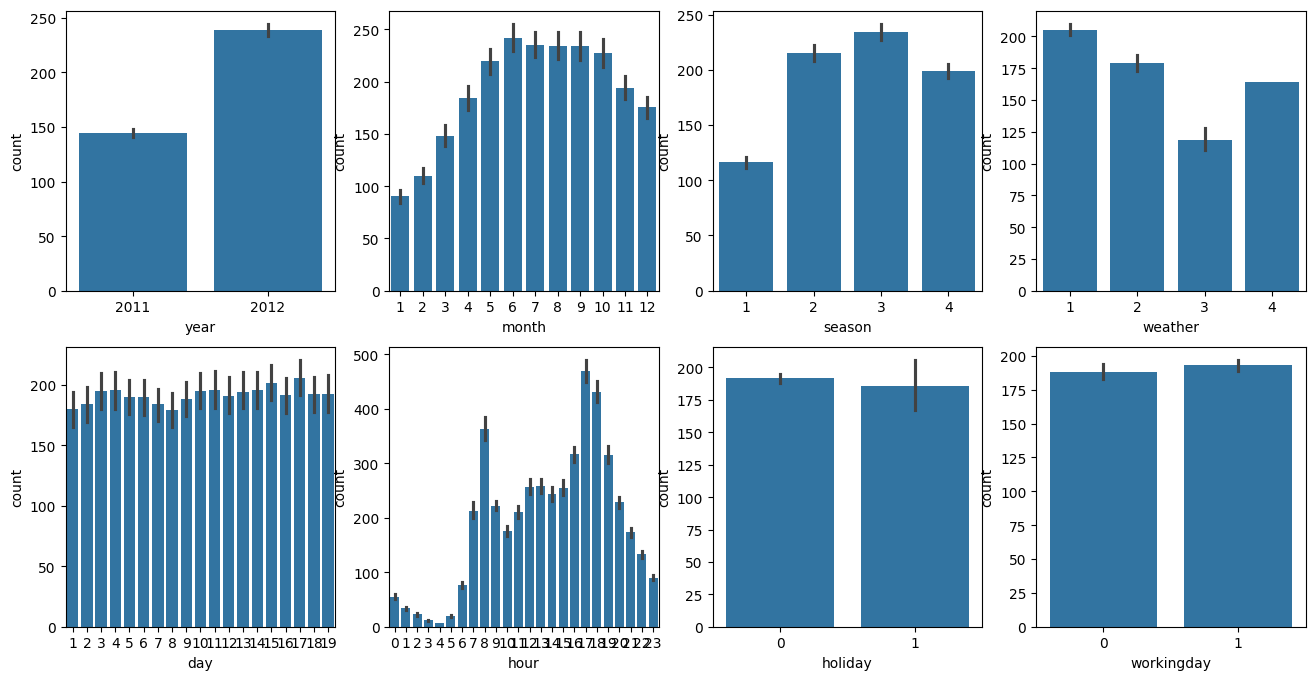

In [37]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']
#cat_features에 있는 모든 칼럼별로 모든 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i ,feature in enumerate(cat_features):
  row = int(i/4)
  col = i%4
  # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
  sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

- year: 2012년이 2011년보다 상대적으로 값이 높음 (시간이 지날수록 자전거 대여 횟수가 지속적으로 증가한 결과, 연도에 특별한 의미가 있는 것은 아님)
- month: 1,2,3월이 낮고, 6,7,8,9월이 높음
- season: 봄, 겨울이 낮고 여름, 가을이 높음
- weather: 눈 또는 비가 있는 경우가 낮고, 맑거나 약간 안개가 있는 경우가 높음
- hour: 오전 출근 시간(8)과 오후 퇴근 시간(17,18)이 상대적으로 높음
- day: 차이가 크지 않음
- holiday, workingday: 주중일 경우가 상대적으로 약간 높음

다음으로 다양한 회귀 모델을 데이터 세트에 적용하여 예측성능을 측정해보자
- 성능평가방법: RMSLE(Root Mean Square Log Error, 오류 값의 로그에 대한 RMSE)

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# 사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y, pred):
  return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
  y = np.maximum(y, 0)
  pred = np.maximum(pred, 0)
  rmsle_val = rmsle(y, pred)
  rmse_val = rmse(y, pred)
  # MAE는 사이킷런의 mean_absolute_error()로 계산
  mae_val = mean_absolute_error(y, pred)
  print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

** rmsle()함수 생성 시 주의점
- 넘파이의 log()를 이용하거나 사이킷 런의 mean_squared_log_error()를 이용하기도 하지만 데이터 값의 크기에 따라 오버플로.언더플로 오류가 발생하기 쉬우므로 log1p()함수를 이용
- log1p() 함수 -> expm1() 함수로 원래의 스케일로 복원 가능

In [39]:
# 다음과 같은 rmsle 구현은 오버플로나 언더플로 오류를 발생하기 쉽습니다.
from sklearn.metrics import mean_squared_log_error
def rmsle(y, pred):
    msle = mean_squared_log_error(y, pred)
    rmsle = np.sqrt(msle)
    return rmsle

**로그 변환, 피처 인코딩과 모델 학습/예측/평가**

이제 회귀 모델을 이용한 자전거 대여 횟수를 예측해보자

예측 평가 전, 데이터 세트 전처리 확인
- 결과값이 정규 분포로 되어 있는지
- 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처가 인코딩이 되어있는지  

In [40]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.284, RMSE: 140.186, MAE: 104.193


실제 Target 데이터 값인 대여 횟수(count)를 감안했을 때 예측 오류로서 비교적 큰값에 해당하기 때문에 실제값과 예측값이 어느 정도 차이가 나는지 오류 값이 가장 큰 순으로 5개를 확인해보자.

In [41]:
def get_top_error_data(y_test, pred, n_tops=5):
  # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성.
  result_df = pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predicted_count'] = np.round(pred)
  result_df['diff'] = np.abs(result_df['real_count']) - result_df['predicted_count']

# 예측값과 실제 값이 가장 큰 데이터 순으로 출력.
  print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2277         813            267.0  546.0


실제 값을 감안했을 때 예측 오류가 큰 것으로 확인할 수 있음

-> 확인사항: Target값의 분포가 왜곡된 형태를 이루는지 확인 (Target값은 정규분포 형태가 가장 좋음)

<Axes: >

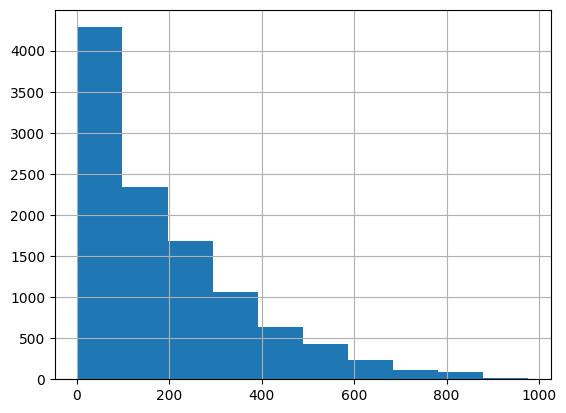

In [42]:
y_target.hist()

- count칼럼의 값이 정규분포가 아닌 0~200 사이에서 왜곡된 것을 확인 가능
- 이를 정규분포의 형태를 띠도록 변경해야 함 -> log 변환 이용

<Axes: >

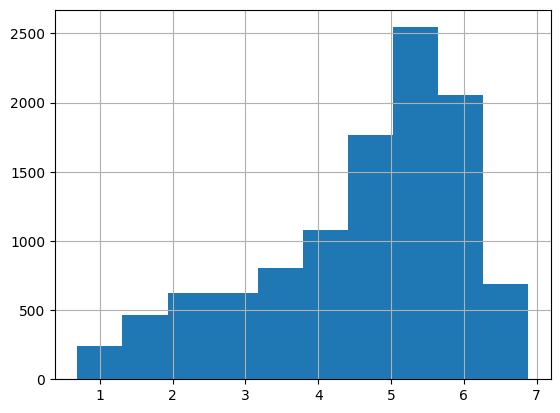

In [43]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

- 왜곡 정도가 약간은 완화된 것을 확인 가능

-> 이를 재학습 후 평가 진행

In [44]:
# 타깃 칼럼이 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target값은 로그 변환 되었으므로 다시 expm1을 이용하여 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습되어 예측 됐으므로 다시 expm1으로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


- RMSLE 오류는 줄었으나, RMSE의 오류는 늘어남

이를 해결하기 위해 개별 피처들의 인코딩을 적용해보자.

먼저 각 피처의 회귀 계숫값을 시각화하자.

<Axes: ylabel='None'>

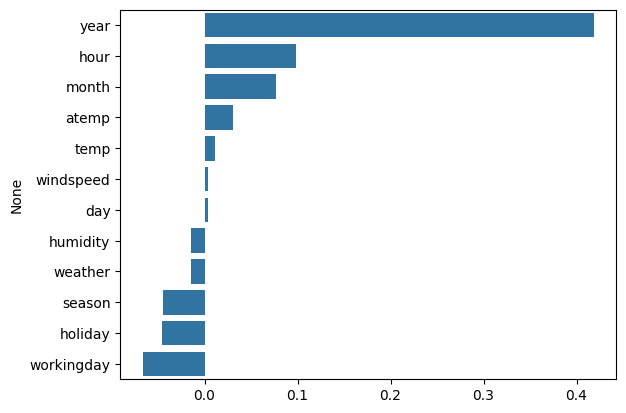

In [45]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

- year, hour, month, season, holiday, workingday 피처들의 회귀 계수 영향도가 상대적으로 높게 측정됨

-> year, hour, month 등은 숫자 값으로 표현되었지만 이들은 모두 category형 피처이기 때문에 숫자형 값에 영향을 받으면 안됨
- get_dummies()를 이용한 원-핫 인코딩 진행

In [46]:
# 'year', ;month', 'day', 'hour' 등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])

LinearRegression, Ridge, Lasso 를 모두 학습하여 예측성능을 확인

In [47]:
# 원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할.
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  if is_expm1:
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###', model.__class__.__name__,'###')
  evaluate_regr(y_test, pred)
# end of function get_model_predict

# 모델별로 평가수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


- 원-핫 인코딩을 적용하니 선형 회귀 예측 성능이 많이 향상된 것을 확인 가능

-> 이를 다시 회귀 계수가 높은 피처들로 시각화

<Axes: ylabel='None'>

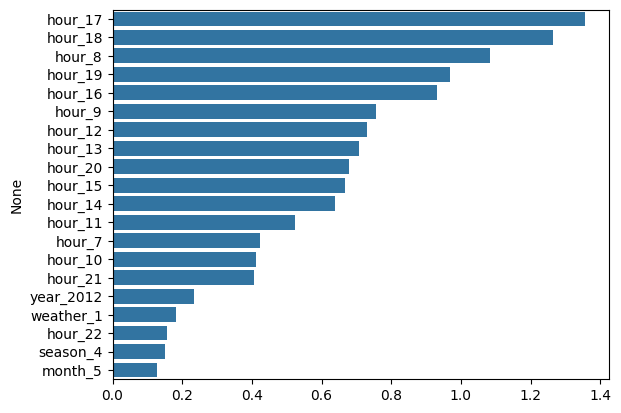

In [48]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

회귀 트리를 이용한 회귀 예측 수행
- Target 값의 로그 변환딘 값과 원-핫 인코딩된 피처 데이터 세트를 그대로 이용하여 랜덤 포레스트, GBM, XGBoost, LightGBM을 순차적으로 성능평가 진행

In [49]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
  # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능, ndarray로 변환.
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.353, RMSE: 50.168, MAE: 31.076
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.340, MAE: 32.743
### XGBRegressor ###
RMSLE: 0.339, RMSE: 51.475, MAE: 31.357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


앞의 선형 회귀 모델보다 회귀 예측 성능이 개선된 것을 확인 가능

###**10. 회귀 실습 - 캐글 주택 가격: 고급 회귀 기법**
- 79개의 변수로 구성된 미국 아이오와 주의 에임스(Ames) 지방의 주택 가격 정보를 가짐
- 성능평가: RMSLE로 진행
- 가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 비중이 높으므로 이를 상쇄하기 위한 오류 값을 로그변환한 RMSLE를 이용

**데이터 사전 처리(Preprocessing)**

In [50]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


- target: SalePrice

In [51]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n 전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수: \n', isnull_series[isnull_series >0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

 전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 칼럼과 그 건수: 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


- 데이터: 1460개의 레코드, 81개의 피처로 구성
- 피처 타입: Target을 제외한 80개의 피처중 43개가 문자형, 나머지 숫자형
- 데이터양에 비해 Null값이 많은 피처도 존재 -> Null값이 너무 많은 피처는 드롭

회귀 모델을 적용하기 전 타깃값의 분포도가 정규분포인지 확인하도록 하자

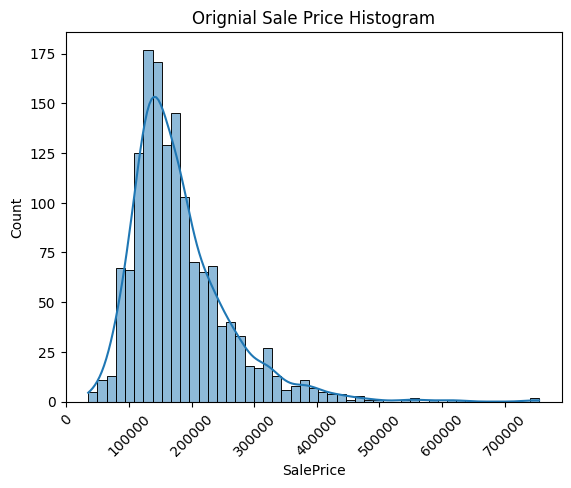

In [52]:
plt.title('Orignial Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(house_df['SalePrice'],kde=True)
plt.show()

- 데이터 값의 분포가 중심에서 왼쪽으로 치우친 형태로, 정규분포에서 벗어남을 확인 가능

 -> 정규 분포 형태로 변환하기 위해 로그 변환을 적용

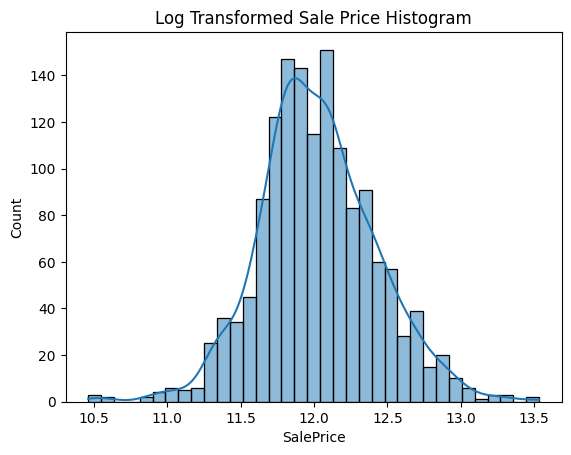

In [53]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

- 로그 변환 시 정규 분포 형태로 결과값이 분포하는 것을 확인 가능
  
  ->이를 SalePrice로그 변환을 진행하여 DataFrame에 반영

다음으로 위에서 말한 로그 변환 및 Null 피처의 전처리르 수행해보자. 내용은 다음과 같다.
- Null 값이 많은 피처인 PoolQC, MiscFeature, Alley, Fence, FireplaceQu는 삭제, id의 경우도 단순 식별자 이므로 삭제
- LotFrontage는 Null값이 259개로 많은 편이나 이를 평균값으로 대체
- 나머지는 Null값이 그렇게 많지 않으므로 숫자형의 경우 평균값으로 대체


In [54]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
# house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
cols_to_drop = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
existing_cols = [col for col in cols_to_drop if col in house_df.columns]
house_df.drop(existing_cols, axis=1, inplace=True)

# 드롭하지 않은 숫자형 Null 칼럼은 평균값으로 대체
num_cols = house_df.select_dtypes(include=[np.number]).columns
house_df[num_cols] = house_df[num_cols].fillna(house_df[num_cols].mean())

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() >0]
print('## Null 피처의 Type: \n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


- 문자형 피처를 제외하고 Null값이 없는 것을 확인할 수 있음,
  
  -> 문자형 피처를 모두 get_dummies()를 이용한 원-핫 인코딩으로 변환

In [55]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() >0]
print('## Null 피처의 Type: \n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 270)
## Null 피처의 Type: 
 Series([], dtype: object)


- 원-핫 인코딩 이후 피처의 개수가 증가함
- Null 값을 가지는 피처는 존재하지 않는 것을 확인 가능

이제 데이터 세트를 학습과 테스트 데이터 세트로 분할하여 사이킷런의 LinearRegression, Ridge, Lasso를 이용하여 선형 계열의 회귀 모델을 만들어보자

**선형 회귀 모델 학습/예측/평가**
- 예측평가: RMSLE
- 타깃값이 이미 로그 변환되었으므로 예측결과 오류에 RMSE만 적용해도 MSLE가 자동으로 구해짐

In [56]:
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__,'로그 변환된 RMSE:', np.round(rmse, 3))
  return rmse

def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

- get_rmse(model)은 단일모델의 RMSE값을 반환하고, get_rmses(models)는 여러 모델의 RMSE값을 반환함

이제 선형 회귀 모델을 학습하고 예측, 평가하도록 하자

In [57]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.127
Lasso 로그 변환된 RMSE: 0.176


[np.float64(0.13183184688250857),
 np.float64(0.1274058283626616),
 np.float64(0.17628250556471403)]

- 라쏘회귀의 회귀 성능이 타 회귀 방식보다 많이 떨어지는 결과가 도출

 -> 라쏘의 경우 최적의 하이퍼파라미터 튜닝이 필요함을 확인 가능


In [58]:
def get_top_bottom_coef(model,n=10):
  # coef_ 속성을 기반으로 Series 객체를 생성, index는 칼럼명.
  coef = pd.Series(model.coef_, index=X_features.columns)

  # + 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환.
  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

해당 함수를 이용하여 모델별 회귀 계수 시각화 진행

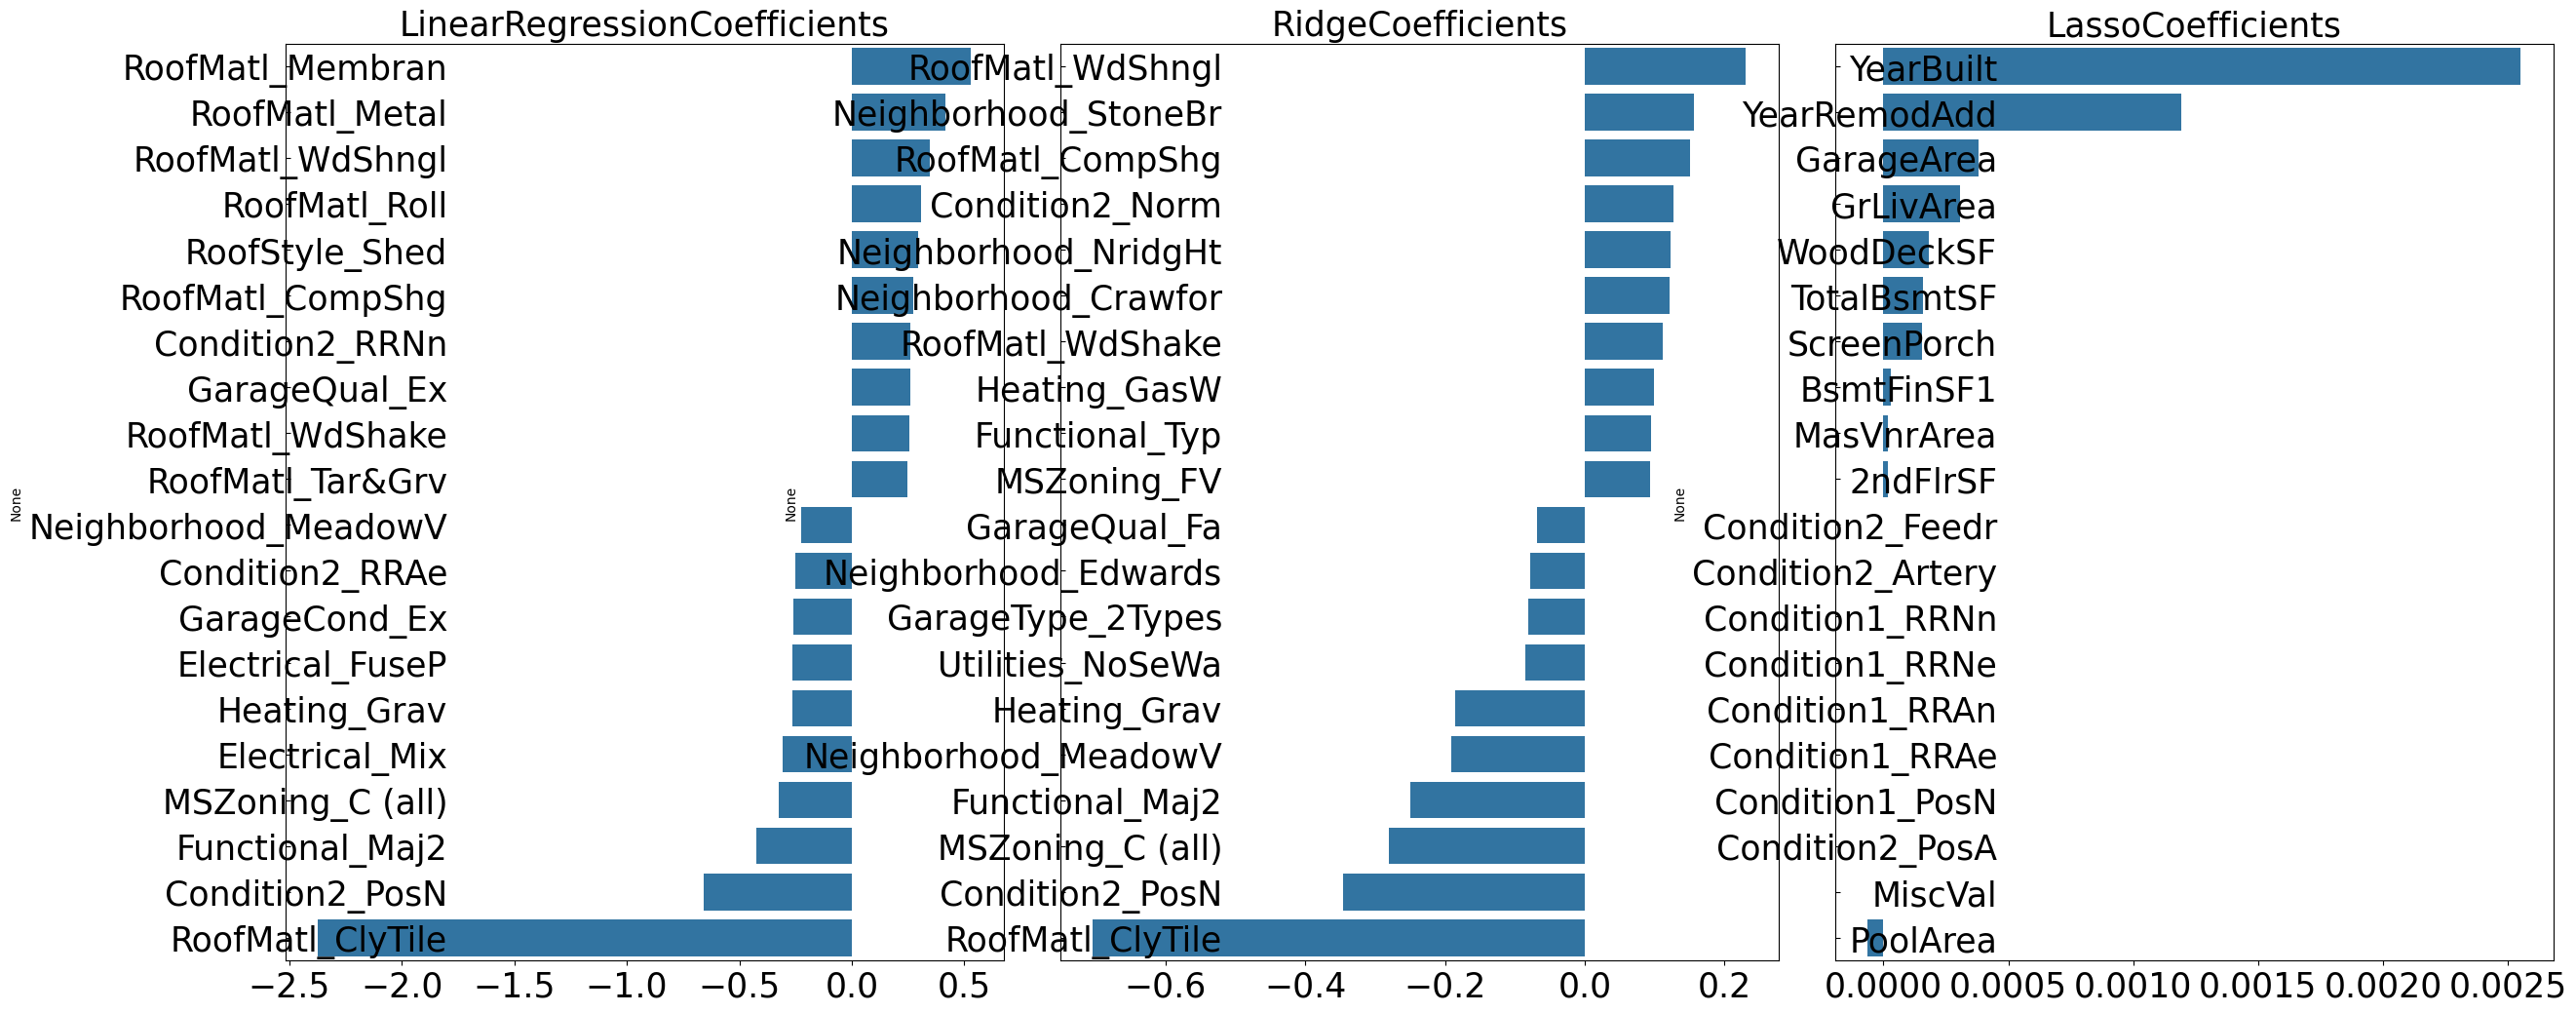

In [59]:
def visualize_coefficient(models):
  # 3개의 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
  fig, axs =plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
  fig.tight_layout()
  # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화.
  for i_num, model in enumerate(models):
    # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])
    # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
    axs[i_num].set_title(model.__class__.__name__+'Coefficients',size=25)
    axs[i_num].tick_params(axis="y", direction="in", pad=-120)
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
      label.set_fontsize(25)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- OLS 기반의 LinearRegression과 Ridge의 경우 회귀 계수가 유사한 형태로 분포되어 있으나 라쏘는 회귀 계수값이 매우 작은 것을 확인 가능

라쏘를 진행할 때만 학습과 테스트 데이터 세트를 분할하지 않고 이를 5개의 교차 검증 폴드 세트로 분할하여 평균 RMSE 값을 측정하자.

In [60]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

  for model in models:
    # 분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별 CV RMSE 갑과 평균 RMSE 출력
    rmse_list = np.sqrt(-cross_val_score(model, X_features,y_target, scoring='neg_mean_squared_error', cv=5))
    rmse_avg = np.mean(rmse_list)
    print('\n{0} CV RMSE값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
    print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 ridge_reg, lasso_reg 모델의 CV RMSE 값 출력
models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


Ridge CV RMSE값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


- 여전히 라쏘가 릿지모델에 비하여 성능이 떨어지는 것을 확인 할 수 있음

 -> alpha 하이퍼 파라미터를 변화시키며 최적값을 도출해보자

In [61]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
  grid_model.fit(X_features, y_target)
  rmse = np.sqrt(-1*grid_model.best_score_)
  print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha: {2}'. format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))

ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha: {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


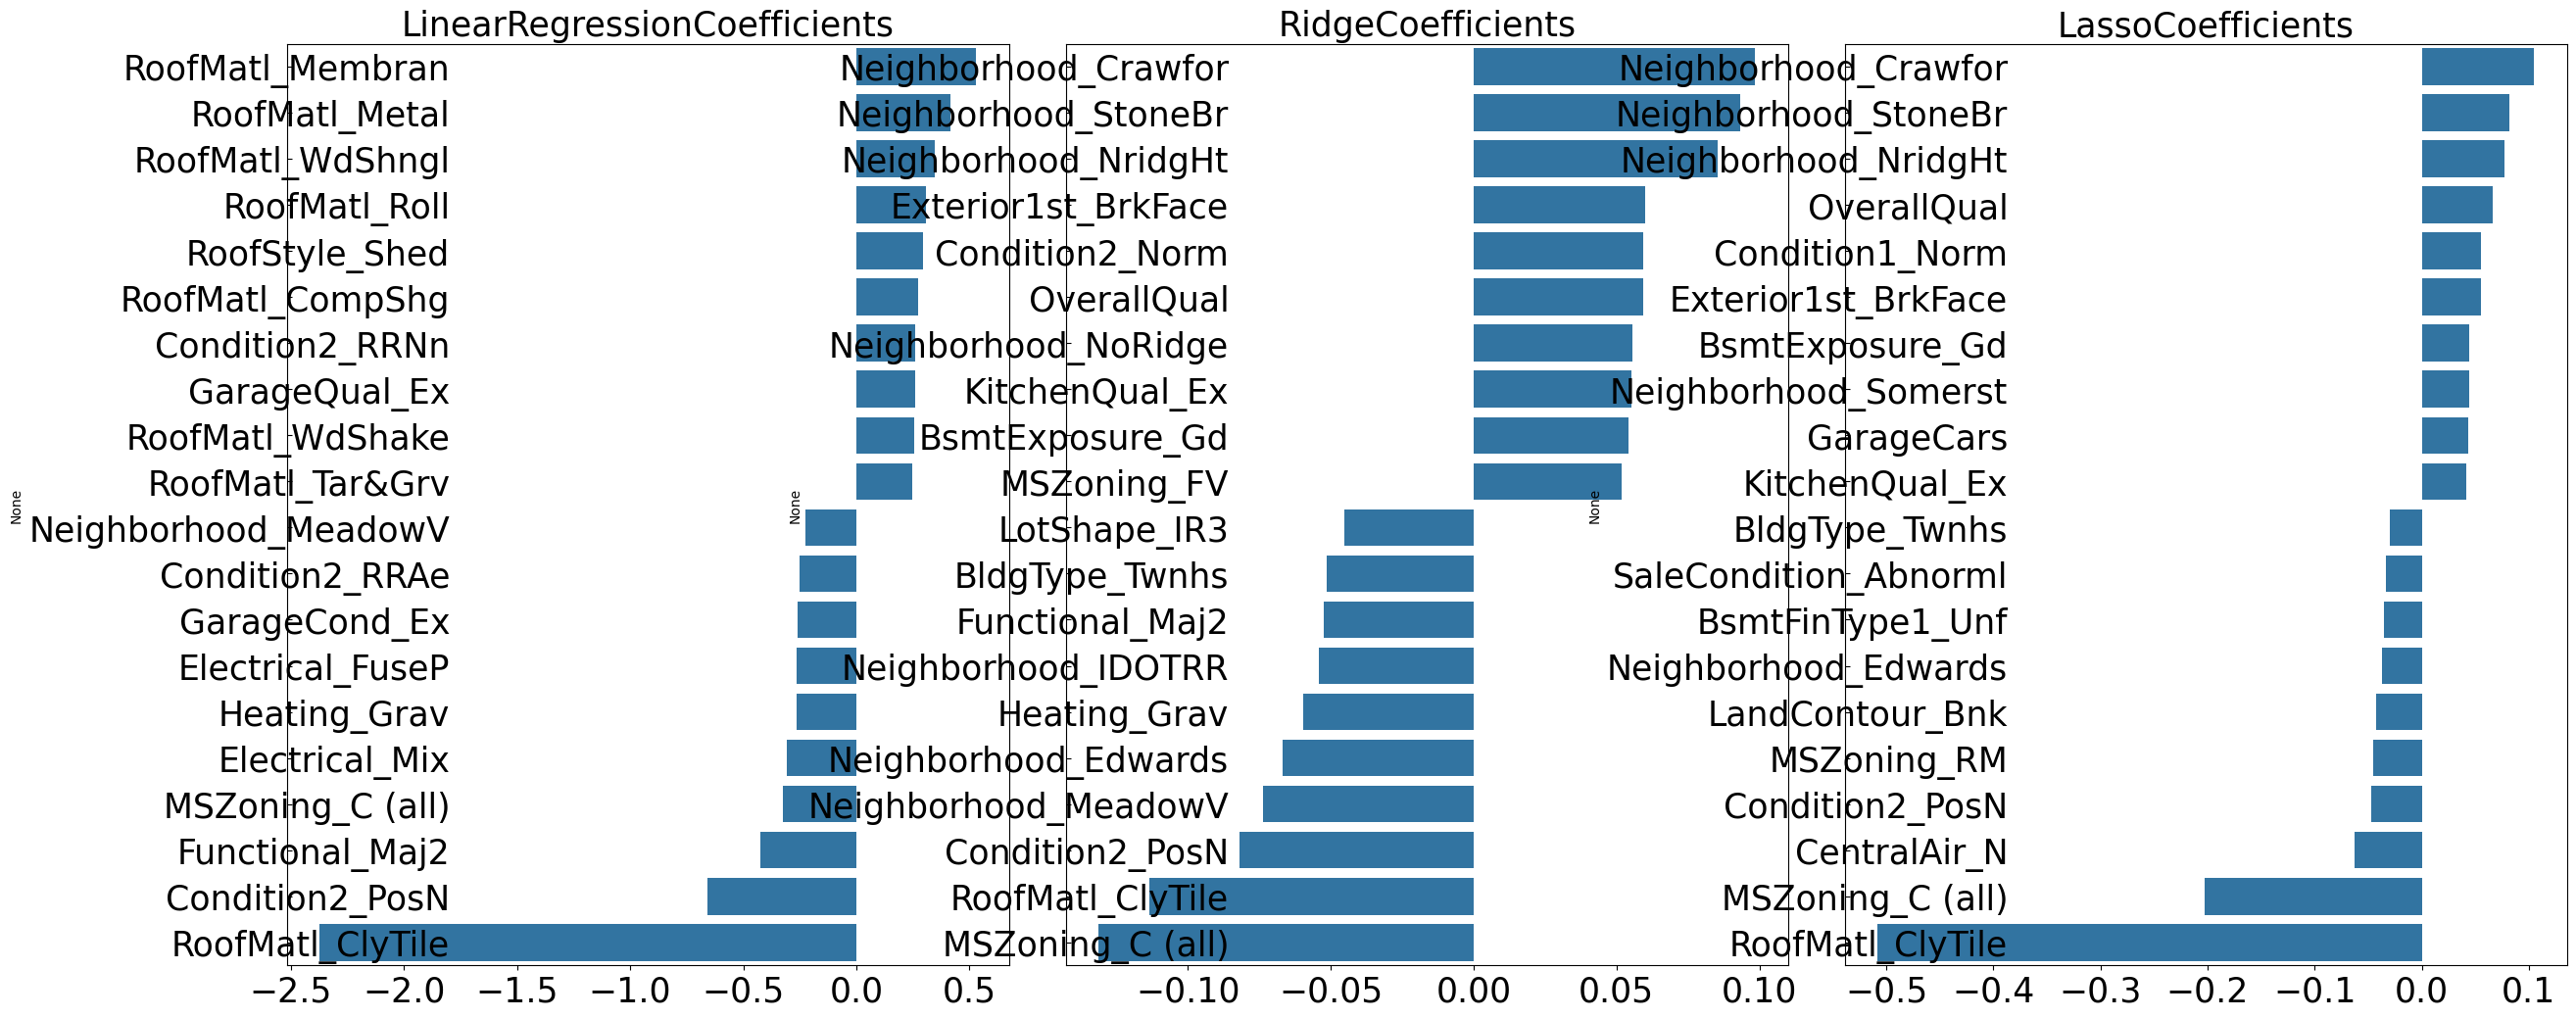

In [62]:
# 앞의 최적화 alpha값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- alpha 최적화 이후 테스트 데이터 세트의 예측성능이 더 좋아진 것을 확인 가능

데이터 세트를 추가적으로 가공해서 모델튜닝을 더 진행해보자. 이때 크게 2가지를 살펴보자.
1. 피처 데이터 세트의 데이터 분포도
2. 이상치(Outlier) 데이터 처리

1) 피처 데이터 세트의 데이터 분포도
- skew()함수를 이용하여 칼럼의 데이터 세트의 왜곡된 정도를 추출 : 반환값이 1 이상인 경우를 왜곡 정도가 높다고 판단(상황에 따라 편차 존재)

**주의할 점: skew()를 적용하는 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 피처는 제외해야 함

In [63]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환.apply lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x: skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features >1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


추출된 왜곡 정도가 높은 피처를 로그변환

In [64]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [66]:
# 왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코딩을 적용하고 피처/타깃 데이텉 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha':[0.05, 0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1275, 최적 alpha: {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1252, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


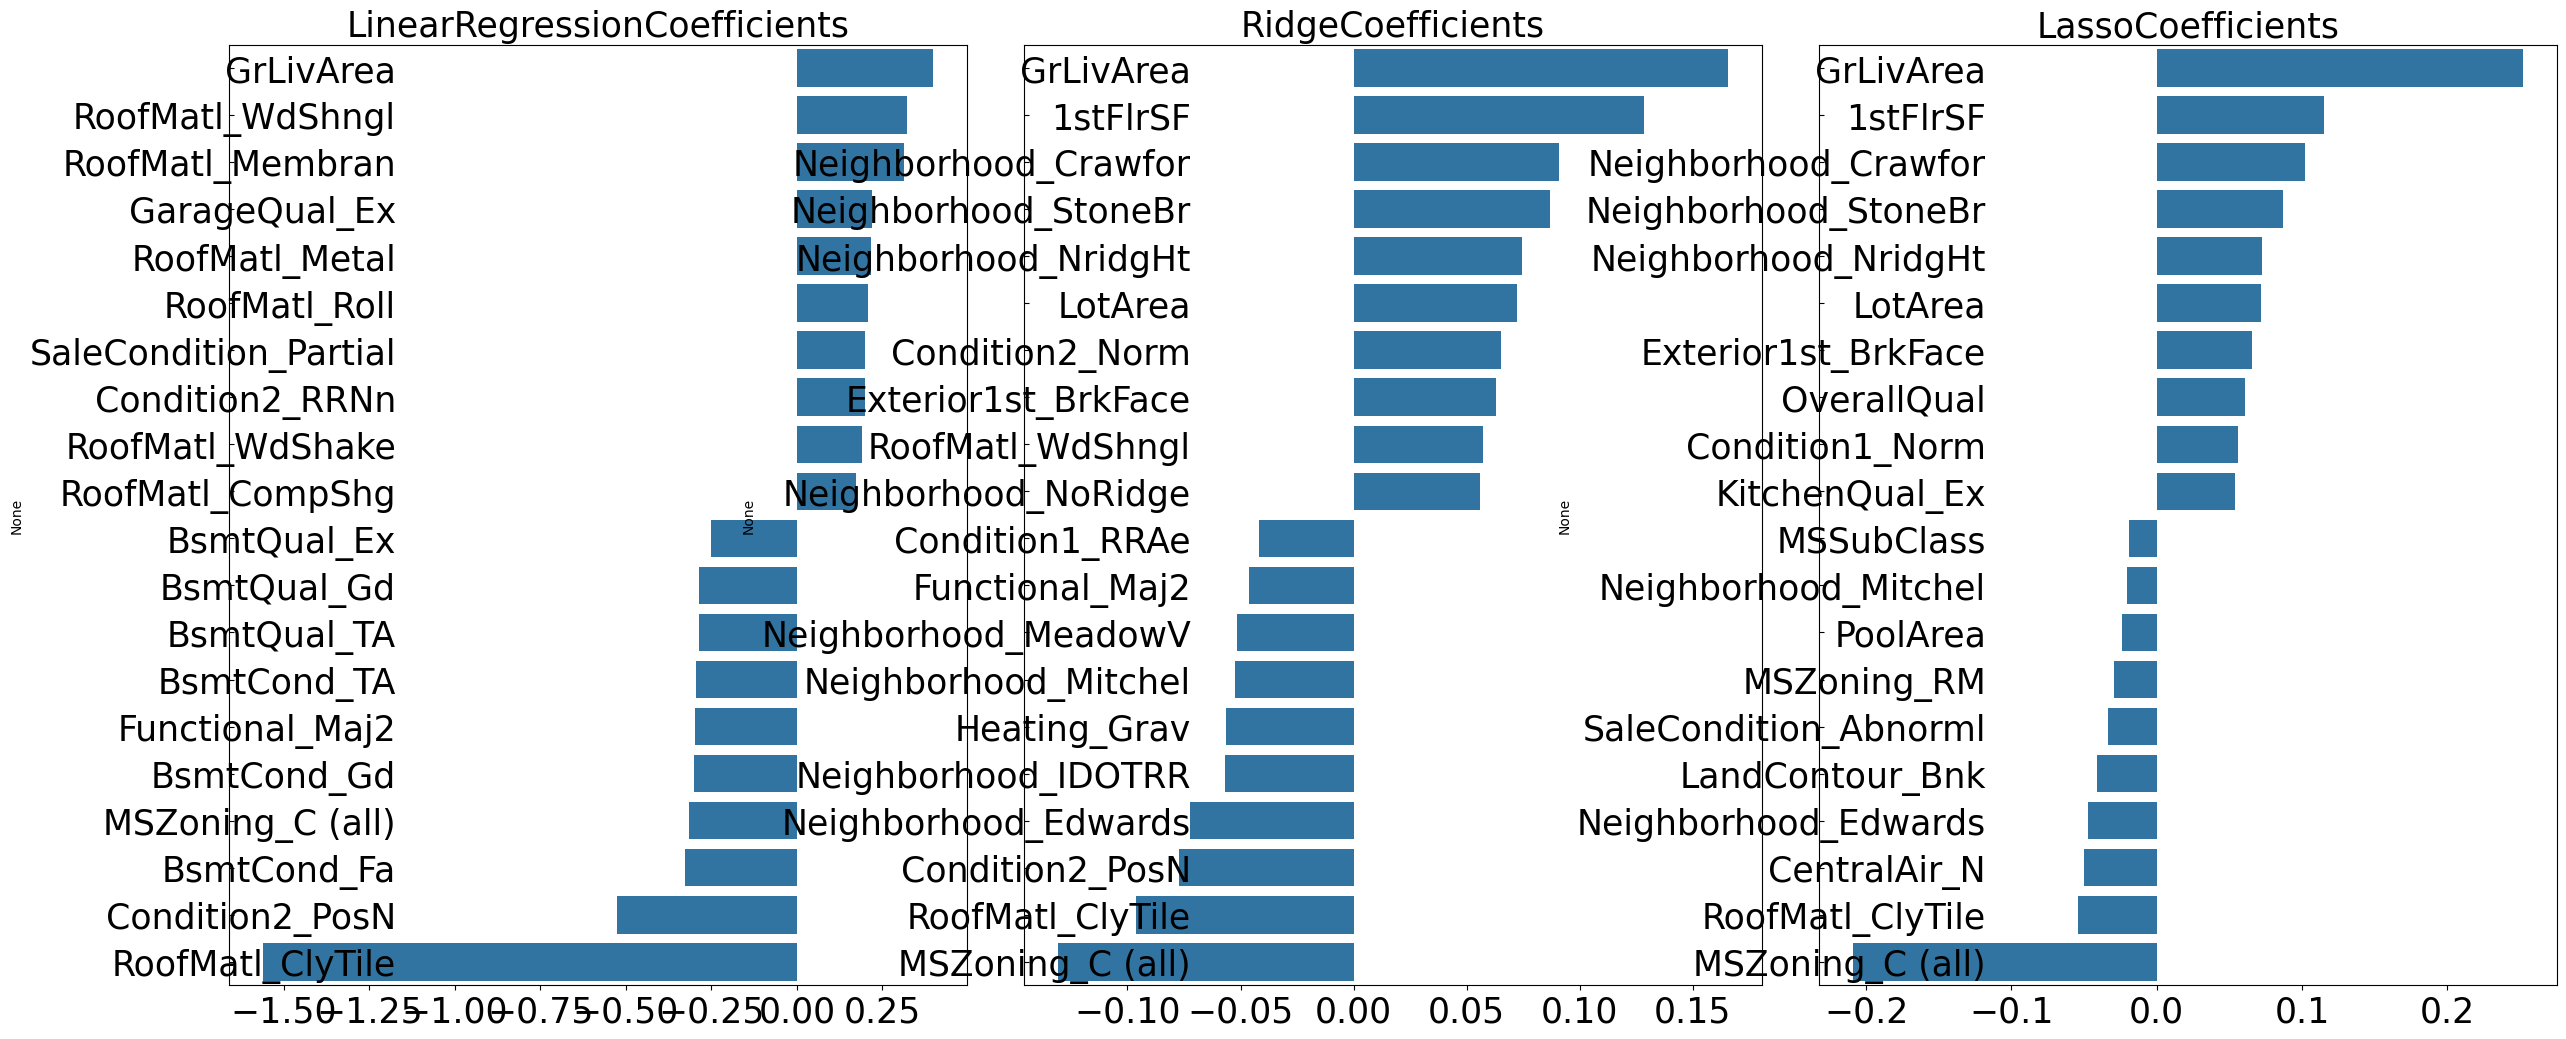

In [68]:
# 앞의 최적화 alpha값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

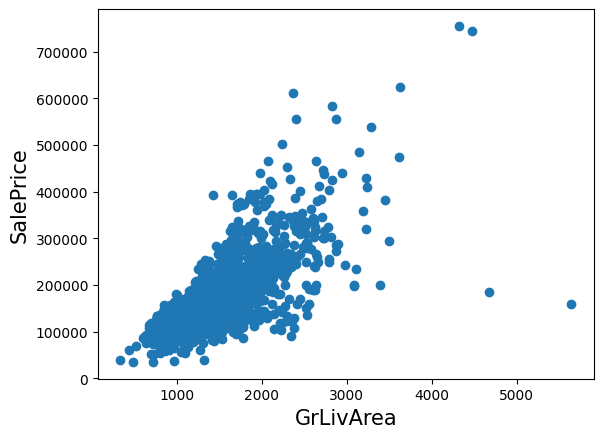

In [67]:
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice',fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [69]:
# GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성.
cond1 = house_df_ohe['GrLivArea'] >np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1&cond2].index

print('이상치 레코드 index:', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제.
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

이상치 레코드 index: [ 523 1298]
이상치 삭제 전 house_df_ohe shape: (1460, 270)
이상치 삭제 후 house_df_ohe shape: (1458, 270)


In [70]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha':[0.05, 0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha': [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1125, 최적 alpha: {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 alpha: {'alpha': 0.001}


**회귀 트리 모델 학습/예측/평가**
- XGBoost, LightGBM을 이용하여 5폴드 세트에 대한 평균 RMSE값 구하기

In [71]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.1206, 최적 alpha: {'n_estimators': 1000}


In [72]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10,n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3155
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 171
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3167
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 168
[LightGBM] [Info] Start training from score 12.023516
[LightGBM] [Warning] Found

**회귀 모델의 예측 결과 혼합을 통한 최종 예측**
- 개별 회귀 모델의 예측 결괏값을 혼합하여 이를 기반을 최종 회귀 값을 예측
- A모델 예측값의 40%, B모델 예측값의 60%를 더해 최종 회귀 값으로 예측하는 것을 혼합한다고 정의


In [76]:
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test, pred_value)
    rmse = np.sqrt(mse)
    print('{0} 모델의 RMSE:{1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최족 예측값 도출
pred = 0.4 *ridge_pred + 0.6*lasso_pred
preds = {'최종 혼합':pred, 'Ridge': ridge_pred, 'Lasso':lasso_pred}

# 최종 혼합모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE:0.10006075517615193
Ridge 모델의 RMSE:0.10340697165289348
Lasso 모델의 RMSE:0.10024171179335342


In [77]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)
pred = 0.4*xgb_pred + 0.5*lgbm_pred
preds = {'최종 혼합': pred, 'XGBM':xgb_pred, 'LGBM': lgbm_pred}

get_rmse_pred(preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 172
[LightGBM] [Info] Start training from score 12.025343
최종 혼합 모델의 RMSE:1.2114566305010852
XGBM 모델의 RMSE:0.10761344291735733
LGBM 모델의 RMSE:0.10363891833477148


**스태킹 앙상블 모델을 통한 회귀 예측**
- 스태킹 모델에는 개별적인 기반 모델과 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어 학습하는 최종 메타 모델, 이렇게 2가지의 모델이 필요함
- 스태킹 모델의 핵심: 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합하여 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것


In [83]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  # 지정된 n_folds값으로 KFold를 생성.
  kf = KFold(n_splits=n_folds, shuffle=False)
  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    #입력된 학습 데이ㅓ에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t폴드 세트:',folder_counter, '시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습데이터로 기반 모델의 학습 수행.
    model.fit(X_tr, y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
    train_fold_pred[valid_index,:] = model.predict(X_te).reshape(-1,1)
    # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장.
    test_pred[:,folder_counter] = model.predict(X_test_n)

  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

  # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

In [84]:
# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환.
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base) 모델이 생성한 학습용/테스트용 데이터 반환.
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
Lasso model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
XGBRegressor model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
LGBMRegressor model 시작
	폴드 세트: 0 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 156
[LightGBM] [Info] Start training from score 12.035561
	폴드 세트: 1 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2951
[LightGBM] [Info] Number of data point

In [85]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합.
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용.
meta_model_lasso = Lasso(alpha=0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/ 테스트 데이터로 메타 모델 예측및 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은: ', rmse)

스태킹 회귀 모델의 최종 RMSE 값은:  0.09704503149148055


스태킹 모델은 분류뿐만 아니라 회귀에서 특히 효과적으로 사용될 수 있는 모델임을 확인 가능